In [1]:
import sys
sys.path.append('/../../QmeQ/qmeq/')
import qmeq

from scipy.linalg import eig, eigvals
import numpy as np

import matplotlib.pyplot as plt
import importlib
import plotting as p

In [2]:
#--SETUP: ---------------------------------------------------------------------------------
eps = 20
V_B = 30
mu_L = -V_B/2       
mu_R = V_B/2        

gammaL = 0.3
gammaR = gammaL
T_L = 20
T_R = 1

In [3]:
#--------------------QmeQ parameters----------------------------------

n = 1 #single resonant energy level

nleads = 2
mulst = {0:mu_L, 1:mu_R}
tlst = {0:T_L, 1:T_R}

tL = np.sqrt(gammaL/np.pi/2)
tR = np.sqrt(gammaR/np.pi/2)

tleads = {(0, 0):tL, (1, 0):tR}

In [5]:


sys = qmeq.Builder(nsingle=n, hsingle={(0,0):eps}, nleads=nleads,
                        mulst=mulst, tlst=tlst, tleads=tleads, dband=1e4, countingleads=[0], kerntype='pyPauli')

# make sure the kernel does not get overwritten
sys.make_kern_copy = True

sys.solve()

I_ss = sys.current_noise[0]
I_var_ss = sys.current_noise[1]
J_QH_ss = sys.heat_current[0]

In [6]:
liouvillian = sys.kern
dim = liouvillian.shape[0]
print(liouvillian.shape)
#print(liouvillian)

(2, 2)


In [7]:
# calculate eigenvalues, left and right eigenvalues
eval_j, left_ev, right_ev = eig(liouvillian, left = True) 

# sort eigenvalues/eigenvectors
idx = eval_j.argsort()[::-1]   
eval_j = eval_j[idx]
left_ev = left_ev[:,idx]
right_ev = right_ev[:,idx] 

In [8]:
#check/normalize normalization

result = np.zeros((dim,dim)) + 0j

for j in range(dim):
    for k in range(dim):
        result[j,k] = np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
        # normalization to 1
        if j == k:
            result[j,k] = result[j,k]/np.dot(np.conjugate(left_ev[:,j]),right_ev[:,k])
            
print(str(np.round(np.real(result),1)))

[[ 1.  0.]
 [-0.  1.]]


In [9]:
#verify that l_1 correspondsto identity
np.real(np.round(2 * left_ev[:,0],0))

array([1., 1.])

In [10]:
# definie initial state
initial = np.array([1,0]) #beginning with an electron in the QD

# calculate stationary state from left/right eigenvectors
rho_ss = 1/np.dot((left_ev[:,0]),right_ev[:,0]) * np.dot(np.conjugate(left_ev[:,0]), initial) * right_ev[:,0]


print('rho_ss from left/right eigenvectors: \n' + str(rho_ss))
print(' \n qmeq solution rho_ss: \n' + str(sys.phi0))
print(' \n difference: ' + str(np.round(sys.phi0 - rho_ss,10).real) )

rho_ss from left/right eigenvectors: 
[0.92262998 0.07737002]
 
 qmeq solution rho_ss: 
[0.92262998 0.07737002]
 
 difference: [0. 0.]


In [11]:
#FULL TIME EVOLUTION:

# define time grid
ti_array = np.linspace(0,10,500)

#dimension
dim = liouvillian.shape[0]

rho_t = np.zeros((dim,ti_array.shape[0])) + 0j

# calculate elements and perform sum
for i in range(dim-1):
    norm = np.dot(np.conjugate(left_ev[:,i+1]),right_ev[:,i+1])
    rho_t += 1/norm * np.dot(np.conjugate(left_ev[:,i+1]), initial) * np.exp(eval_j[i+1] *  ti_array[None,:]) * right_ev[:,i+1,None] 

#add stationary state    
rho_t = rho_t + rho_ss[:,None]

print(rho_t.shape)

(2, 500)


fermi:  (100,)
epsilons:  (100,)
fermi:  (100,)
epsilons:  (100,)


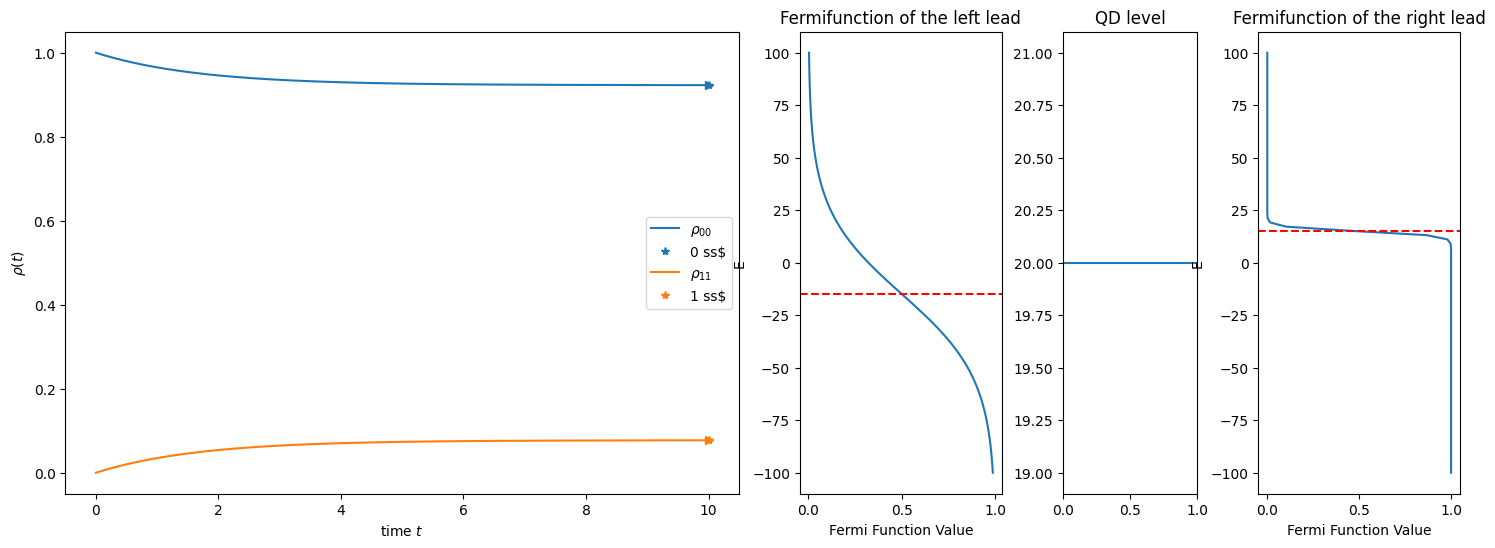

In [24]:
epsilons = np.linspace(-100,100,100)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'width_ratios': [10, 3, 2, 3]}) 

#EVOLUTION OF DIAGONAL COMPONENTS

ax1.plot(ti_array, np.real(rho_t[0]), label = r'$\rho_{00}$')
ax1.plot(ti_array[-1],sys.phi0[0], '>',color = 'C0')
ax1.plot(ti_array[-1],sys.phi0[0], '*',color = 'C0', label = r'0 ss$')

ax1.plot(ti_array, np.real(rho_t[1]), label = r'$\rho_{11}$')
ax1.plot(ti_array[-1],sys.phi0[1], '>',color = 'C1')
ax1.plot(ti_array[-1],sys.phi0[1], '*',color = 'C1', label = r'1 ss$')

ax1.legend()

ax1.set_xlabel(r'time $t$')
ax1.set_ylabel(r'$\rho(t)$')


importlib.reload(p)
p.plot_fermi_function(epsilons, mu_L, T_L, ax2, "Fermifunction of the left lead")
p.plot_qd_level(epsilons, eps, ax3, "QD level")
p.plot_fermi_function(epsilons, mu_R, T_R, ax4, "Fermifunction of the right lead")

In [14]:
# PARTICLE CURRENT

# transient current

# qmeq solution for stationary current 
I_ss = sys.current

I_t_qmeq = np.zeros((nleads,ti_array.shape[0]))
print(I_t_qmeq.shape)
I_t_CF = np.zeros((ti_array.shape[0]))


for i in range(ti_array.shape[0]):
    
    # reset current    
    sys.current[:] = np.zeros(nleads)
    
    # set stationary state to rho_t value
    sys.phi0[:] = np.real(rho_t[:,i])
    
    # calculate current (also calculates energy and heat currents)
    sys.appr.generate_current() # calculates current both ways
    I_t_qmeq[:,i] = sys.current
    I_t_CF[i] = sys.current_noise[0] 
    
    #--------------------------------------------

# current at left and right lead    
IL_t_qmeq = I_t_qmeq[0]
IR_t_qmeq = I_t_qmeq[1]


(2, 500)


Text(0, 0.5, '$I(t)$')

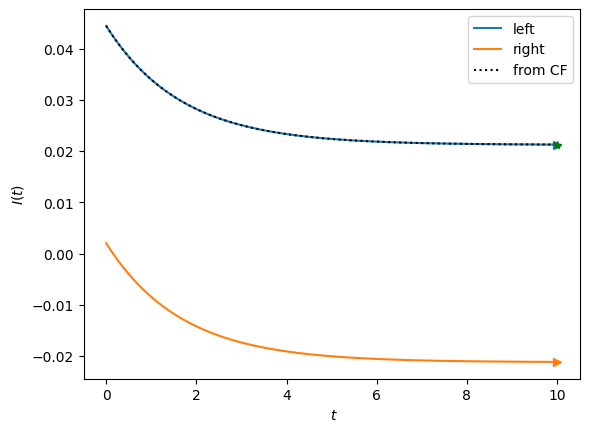

In [15]:
#plotting particle current

plt.plot(ti_array,IL_t_qmeq , label = 'left')
#plt.plot(ti_array[-1], I_ss[0],'*',color = 'black', label = r'qmeq $\rho_{ss}$')
plt.plot(ti_array[-1], I_ss[0], '>', color = 'C0', )

plt.plot(ti_array, IR_t_qmeq ,label = 'right')
plt.plot(ti_array[-1], (I_ss[1]), '>', color = 'C1' , )

plt.plot(ti_array, I_t_CF, ':', color = 'black', label = r'from CF')

plt.plot(ti_array[-1], I_ss[0], '*', color='green')

plt.plot

plt.legend()

plt.xlabel(r' $t$')
plt.ylabel(r'$I(t)$')